In [1]:
import xml.etree.ElementTree as ET
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

from tqdm.notebook import tqdm
tqdm.pandas()


In [2]:
import os

data_dir = r"D:\SRC\DS@GT\eRisk25\eRisk25-datasets\task2-contextualized-early-depression\training_data"
print(os.listdir(data_dir))

['2017_cases', '2017_cases.zip', '2018_cases', '2018_cases.zip', '2022_cases', '2022_cases.zip', 'README.txt']


In [3]:
def parse_xml_files(base_dir):
    """
    Parses XML files from specified directories and extracts user ID, date, time, title, text, and case (positive or negative).

    Args:
        base_dir (str): The base directory containing 'pos' and 'neg' subdirectories with XML files.

    Returns:
        pandas.DataFrame: A DataFrame containing the extracted data, or None if no data is found.
    """
    all_data = []

    for case in ['pos', 'neg']:
        case_dir = os.path.join(base_dir, case)
        if not os.path.exists(case_dir):
            print(f"Warning: Directory not found: {case_dir}")
            continue

        for filename in os.listdir(case_dir):
            if filename.endswith('.xml'):
                filepath = os.path.join(case_dir, filename)
                try:
                    tree = ET.parse(filepath)
                    root = tree.getroot()
                    
                    for writing in root.findall('WRITING'):
                        user_id = root.find('ID').text if root.find('ID') is not None else None
                        date_text = writing.find('DATE').text if writing.find('DATE') is not None else None
                        title = writing.find('TITLE').text if writing.find('TITLE') is not None else ""
                        text = writing.find('TEXT').text if writing.find('TEXT') is not None else ""
                        
                        if date_text:
                            parts = date_text.split(" ")
                            date_part = parts if parts else None  # Extract only the date part
                            time_part = parts[1] if len(parts) > 1 else None  # Extract only the time part if available
                            
                            all_data.append({
                                'user_id': user_id,
                                'date': date_part,
                                'time': time_part,
                                'title': title,
                                'text': text,
                                'case': case  # 'pos' or 'neg'
                            })
                        
                except ET.ParseError as e:
                     print(f"Error parsing {filename}: {e}")
                except Exception as e:
                    print(f"An unexpected error occurred with {filename}: {e}")
    if all_data:
        return pd.DataFrame(all_data)
    else:
        print("No data extracted. Please check if files are correctly placed in pos/neg folders.")
        return None

In [4]:
dirs = ['2017_cases', '2018_cases', '2022_cases']

# base_directory = '/Users/sid/Documents/eRisk/'
df = pd.DataFrame()
for dir in dirs:
    full_path = os.path.join(data_dir, dir)
    cases_df = parse_xml_files(full_path)
    cases_df['year'] = dir[:4]
    df = pd.concat([df, cases_df], ignore_index=True)

In [5]:
df

,user_id,date,time,title,text,case,year
0,test_subject1345,"[, 2015-05-20, 05:12:23, ]",2015-05-20,,So many unwanted Smith fadeaways.,pos,2017
1,test_subject1345,"[, 2015-05-20, 04:56:18, ]",2015-05-20,Mid-Range Jumpers,"Hey guys, Celtics fan here pulling hard for t...",pos,2017
2,test_subject1345,"[, 2015-05-01, 05:51:20, ]",2015-05-01,,Well he got 2 tonight so maybe he'll be able ...,pos,2017
3,test_subject1345,"[, 2015-04-30, 13:49:51, ]",2015-04-30,,I mean he'll get pinch hits and an occasional...,pos,2017
4,test_subject1345,"[, 2015-04-30, 05:47:34, ]",2015-04-30,,Yeah you're probably right. Oh well.,pos,2017
...,...,...,...,...,...,...,...
1975695,subject9989,"[2021-12-20, 16:10:16]",16:10:16,Have a laugh! A pharmacy Christmas List to Cor...,None,neg,2022
1975696,subject9989,"[2021-12-20, 16:10:41]",16:10:41,Have a laugh! A pharmacy Christmas List to Cor...,None,neg,2022
1975697,subject9989,"[2021-12-20, 16:11:43]",16:11:43,Have a laugh! A pharmacy Christmas List to Cor...,None,neg,2022
1975698,subject9989,"[2021-12-20, 16:13:10]",16:13:10,Have a laugh! A pharmacy Christmas List to Cor...,None,neg,2022


In [6]:
print(f"Shape: {df.shape}")  # (rows, columns)
print(f"Unique users: {df['user_id'].nunique()}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / (1024**2):.2f} MB")

Shape: (1975700, 7)
Unique users: 2980
Memory usage: 1369.89 MB


Total posts: 1975700
Unique users: 2980
Class distribution:
 case
neg    1837923
pos     137777
Name: count, dtype: int64
Avg posts per user: 662.9865771812081
Missing text: 0.1262458875335324
Missing title: 0.2938695146024194


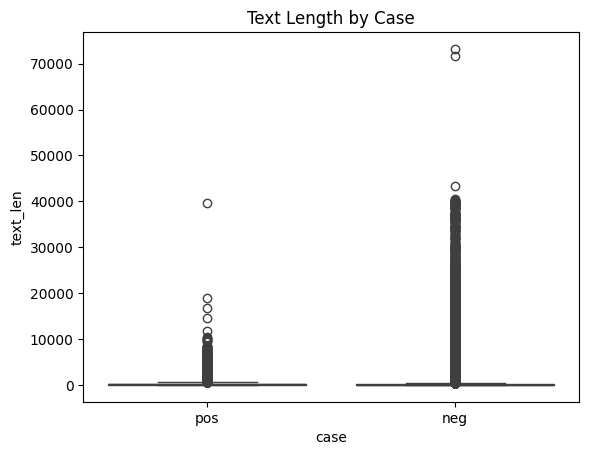

TypeError: no numeric data to plot

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Basic info
print("Total posts:", len(df))
print("Unique users:", df['user_id'].nunique())
print("Class distribution:\n", df['case'].value_counts())

# Posts per user
posts_per_user = df.groupby('user_id').size()
print("Avg posts per user:", posts_per_user.mean())

# Missing text/title
print("Missing text:", df['text'].isna().mean())
print("Missing title:", df['title'].isna().mean())

# Text length (ignore missing)
df['text_len'] = df['text'].dropna().apply(len)
df['title_len'] = df['title'].dropna().apply(len)

# Text length by case
sns.boxplot(data=df.dropna(subset=['text']), x='case', y='text_len')
plt.title("Text Length by Case")
plt.show()

# Posts over time
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['month'] = df['date'].dt.to_period('M')
monthly_posts = df.groupby(['month', 'case']).size().unstack(fill_value=0)
monthly_posts.plot(figsize=(12,5), title="Monthly Posts by Case")
plt.ylabel("Number of Posts")
plt.show()